there are 371 patents
Closest patent assignee is:  Microsoft Corporation
Closest patent assignee is:  salesforce.com, inc.
Closest patent assignee is:  Signature Systems Group, LLC
Closest patent assignee is:  None
Closest patent assignee is:  Apple Inc.
Closest patent assignee is:  Signature Systems Group, LLC
Closest patent assignee is:  Gogroups
Closest patent assignee is:  Gogroups
Closest patent assignee is:  INTERNATIONAL BUSINESS MACHINES CORPORATION
Closest patent assignee is:  Conviva Inc.
Closest patent assignee is:  Symantec Corporation
Closest patent assignee is:  SILICON GRAPHICS INTERNATIONAL CORP.
Closest patent assignee is:  Microsoft Corporation
Closest patent assignee is:  None
Closest patent assignee is:  XCHANGEWITHME, LLC
Closest patent assignee is:  Google LLC
Closest patent assignee is:  Adobe Systems Incorporated
Closest patent assignee is:  STATE FARM MUTUAL AUTOMOBILE INSURANCE COMPANY
Closest patent assignee is:  Microsoft Corporation
Closest patent assignee 

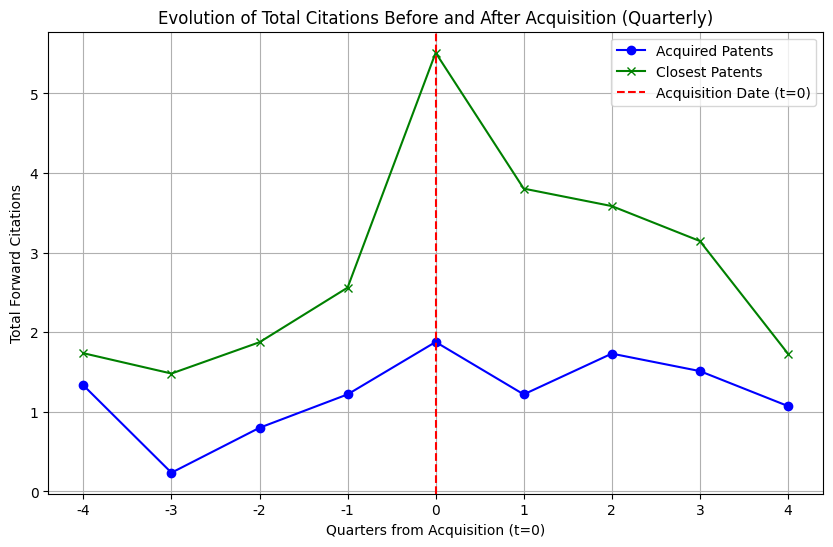

In [1]:
## Inputs
import dill as pickle
from datetime import datetime
from collections import OrderedDict
import time
with open(r"C:\Users\amusali\Downloads\LinkedIn Corporation_2016-12-07_before.pkl", 'rb') as f:
    t = pickle.load(f)
import matplotlib.pyplot as plt
import numpy as np

patents = t
center_date=datetime(2016, 12, 7)
no_closest_patent_counter = 0
no_cited_patent_counter = 0
patents_with_citation = 0

upper_lower_bound = 4
implied_days = 365
threshold = 365
# Initialize dictionaries to hold citation counts for each time point (quarters)

time_range=(-upper_lower_bound, upper_lower_bound)
patent_citations_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
patent_count_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
closest_citations_by_time = {t: 0 for t in range(time_range[0], time_range[1] + 1)}
closest_count_by_time =  {t: 0 for t in range(time_range[0], time_range[1] + 1)}

print("there are", len(patents), "patents")
for patent in patents:
    if patent.cosine_similarity_with_closest_patent is not None:
        if patent.cosine_similarity_with_closest_patent < 0.7:
            continue
    if patent.forward_citations  == 0 or not patent.forward_citations or patent.closest_patent.forward_citations == 0 or not patent.closest_patent.forward_citations :
        no_cited_patent_counter += 1
        continue
    if (patent.date_granted - center_date).days > -threshold or (patent.closest_patent.date_granted - center_date).days > -threshold:
        #print("BEFORE THE ANALYSIS Period")
        continue
    #if -(patent.date_granted - center_date).days < upper_lower_bound * implied_days:
      # print("Too close to the acquistion")
        #continue
    if patent.closest_patent is None:
        print('None closes patent')
        no_closest_patent_counter +=1
        continue

    print("Closest patent assignee is: ", patent.closest_patent.assignee_organization)
    # Check if the patent has any citedby_patents
    if patent.citedby_patents:
        for cited_patent in patent.citedby_patents:
            #print(cited_patent.date_granted)
            # Calculate time difference (in quarters) from the center date
            t_patent = (cited_patent.date_granted - center_date).days // implied_days  # Approx. 91 days in a quarter
            #print(t_patent)
            if time_range[0] <= t_patent <= time_range[1]:
                patent_citations_by_time[t_patent] += 1  # Add 1 citation for this quarter
    time_to_acquisition = (patent.date_granted - center_date).days // implied_days
    
    for key, value in patent_count_by_time.items():
        if key >= time_to_acquisition:
            patent_count_by_time[key] += 1
    # Check if the closest patent exists and has any citedby_patents
    if patent.closest_patent and patent.closest_patent.citedby_patents:
        for cited_patent in patent.closest_patent.citedby_patents:
            t_closest = (cited_patent.date_granted - center_date).days // implied_days  # Time difference in quarters
            if time_range[0] <= t_closest <= time_range[1]:
                closest_citations_by_time[t_closest] += 1 # Add 1 citation for this quarter

    time_to_acquisition = (patent.closest_patent.date_granted - center_date).days // implied_days
    
    for key, value in closest_count_by_time.items():
        if key >= time_to_acquisition:
            closest_count_by_time[key] += 1

    patents_with_citation += 1

print(f"There are {no_closest_patent_counter} patents with no closest patent")
print(f"patents with no citation: {no_cited_patent_counter}")   
print(f"paetnts with citation : {patents_with_citation}")

print(patent_citations_by_time)
print(closest_citations_by_time)
print(patent_count_by_time)
print(closest_count_by_time)

# Calculate average citations for each time point (quarter)
avg_patent_citations = [patent_citations_by_time[t]/patent_count_by_time[t] for t in range(time_range[0], time_range[1] + 1)]
avg_closest_citations = [closest_citations_by_time[t]/closest_count_by_time[t] for t in range(time_range[0], time_range[1] + 1)]




# Create the x-axis (time points in quarters)
time_points = list(range(time_range[0], time_range[1] + 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time_points, avg_patent_citations, label='Acquired Patents', marker='o', color='blue')
plt.plot(time_points, avg_closest_citations, label='Closest Patents', marker='x', color='green')

# Highlight t=0 (acquisition date)
plt.axvline(x=0, color='red', linestyle='--', label='Acquisition Date (t=0)')

plt.title("Evolution of Total Citations Before and After Acquisition (Quarterly)")
plt.xlabel("Quarters from Acquisition (t=0)")
plt.ylabel("Total Forward Citations")
plt.xticks(np.arange(time_range[0], time_range[1] + 1), labels=[f"{i}" for i in range(time_range[0], time_range[1] + 1)])
plt.legend()
plt.grid(True)
plt.show()





In [40]:
import api.citations as cit
import importlib
importlib.reload(cit)

cit.regularize_patents(patents)

Processed patent 0/371
Processed patent 1/371
Processed patent 2/371
Processed patent 3/371
Processed patent 4/371
Processed patent 5/371
Processed patent 6/371
Processed patent 7/371
Processed patent 8/371
Processed patent 9/371
Processed patent 10/371
Processed patent 11/371
Processed patent 12/371
Processed patent 13/371
Processed patent 14/371
Processed patent 15/371
Processed patent 16/371
Processed patent 17/371
Processed patent 18/371
Processed patent 19/371
Processed patent 20/371
Processed patent 21/371
Processed patent 22/371
Processed patent 23/371
Processed patent 24/371
Processed patent 25/371
Processed patent 26/371
Processed patent 27/371


There are 1 patents being fed into BERT
It took 2.88798 seconds to get the embeddings of the input.
Processed patent 28/371
There are 1 patents being fed into BERT
It took 2.41025 seconds to get the embeddings of the input.
Processed patent 29/371


KeyboardInterrupt: 

In [34]:
print(10**-3)

0.001


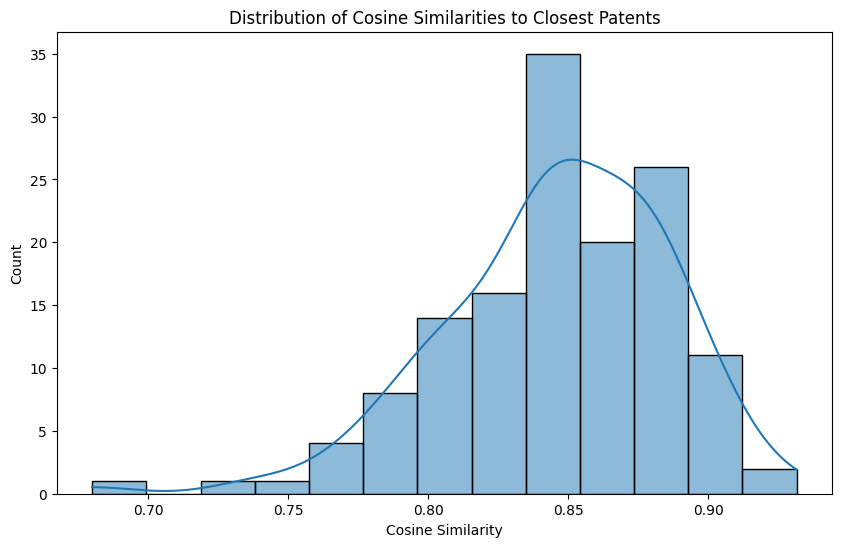

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

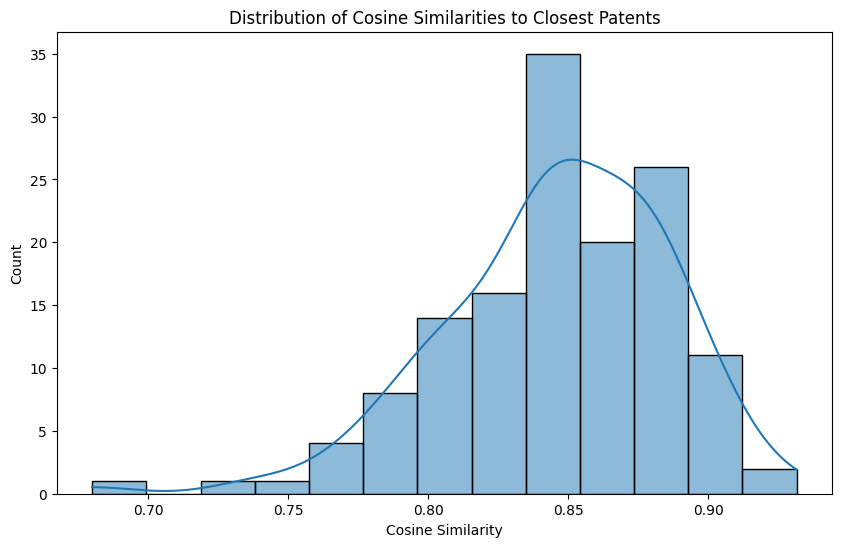

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

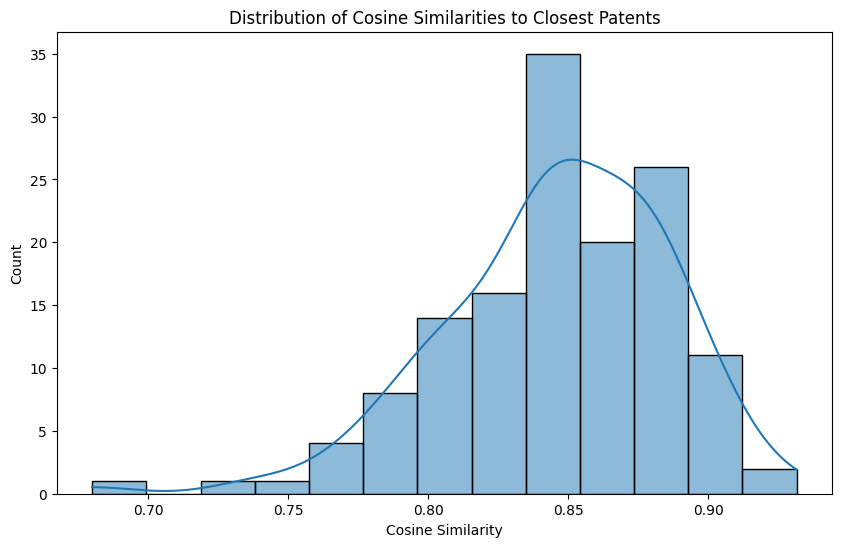

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

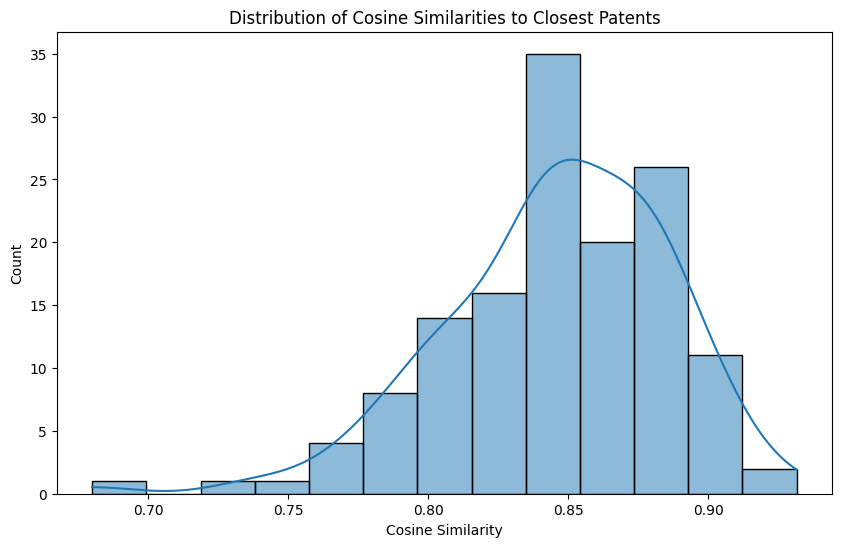

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

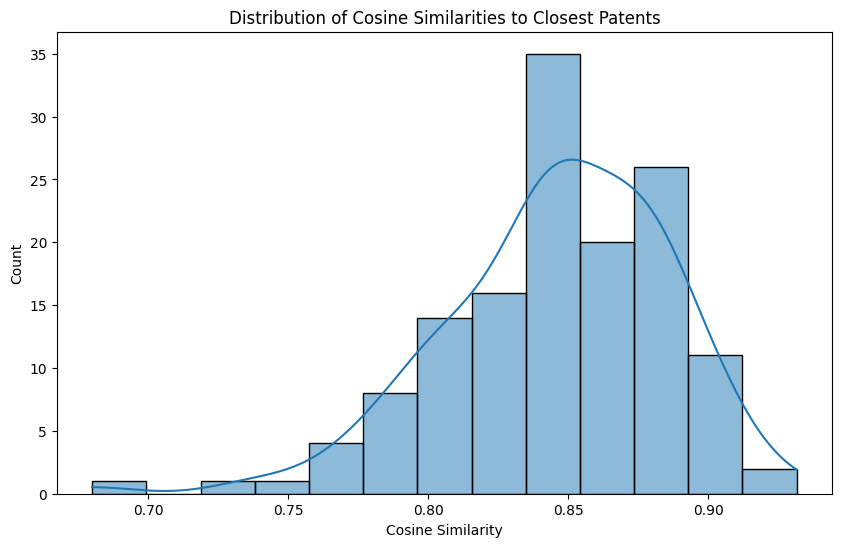

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

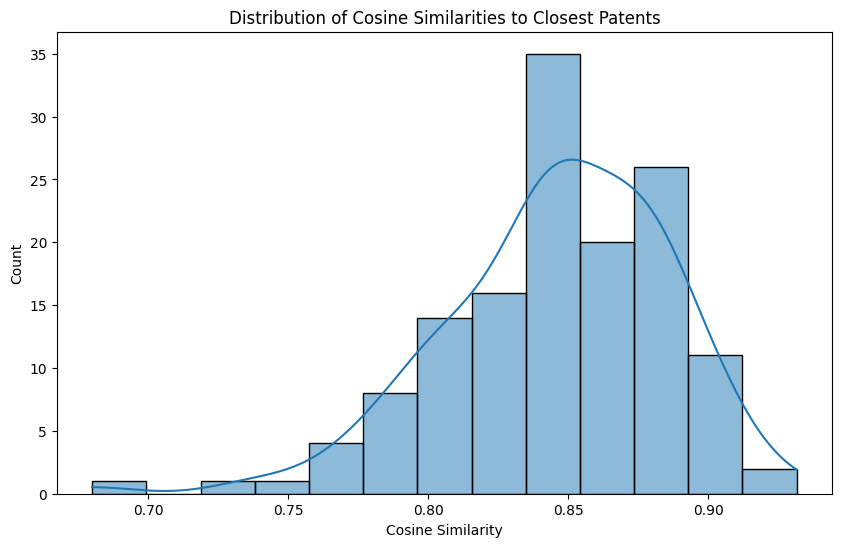

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

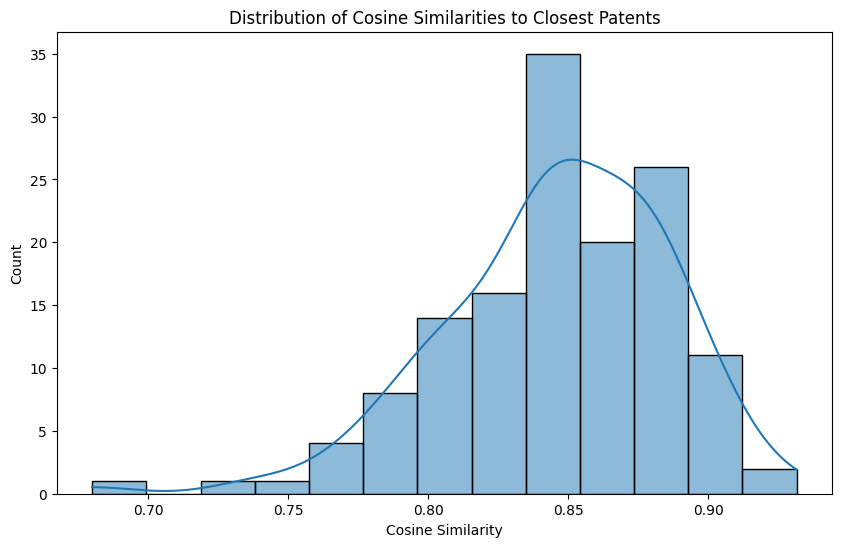

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

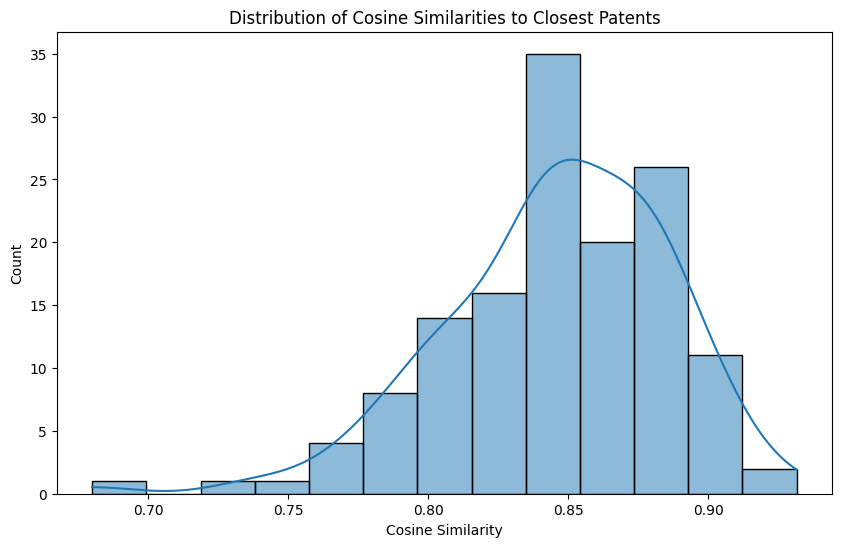

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

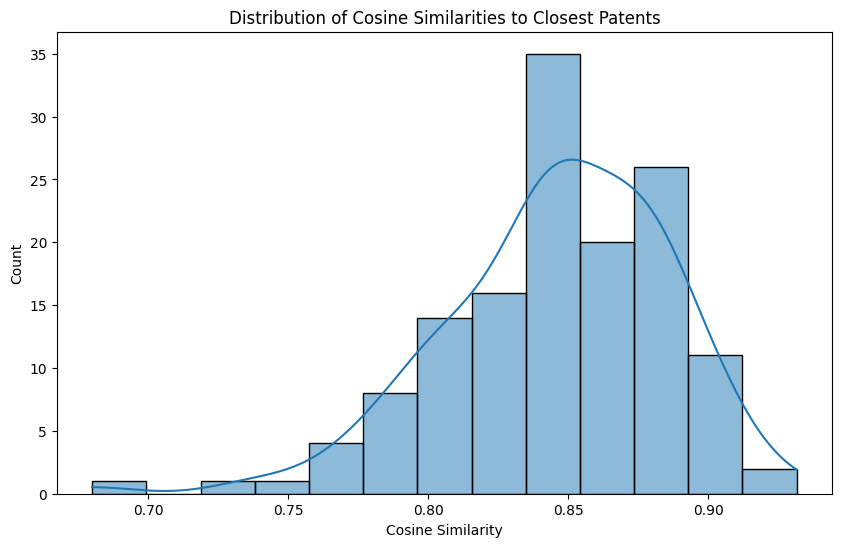

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

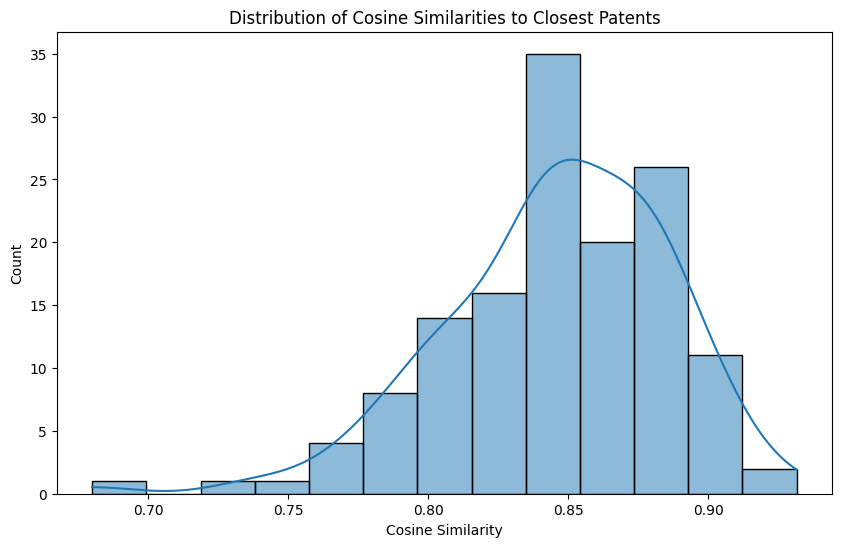

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

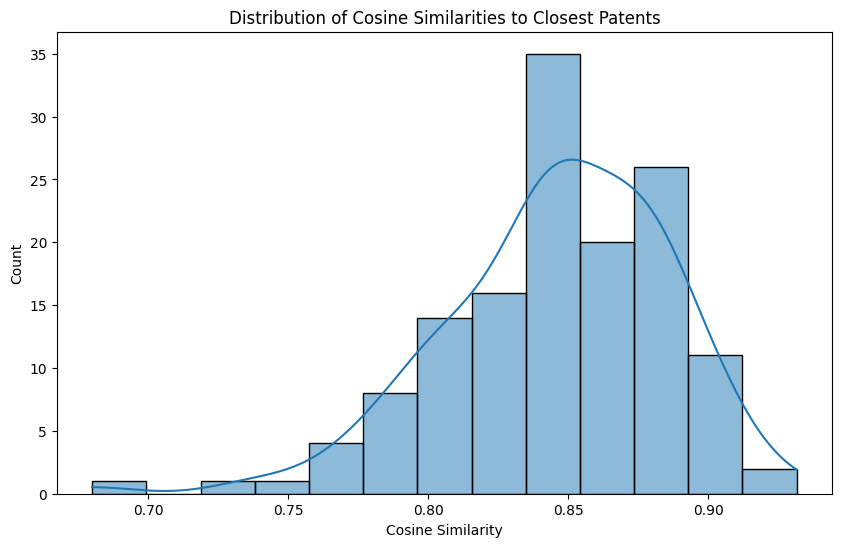

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

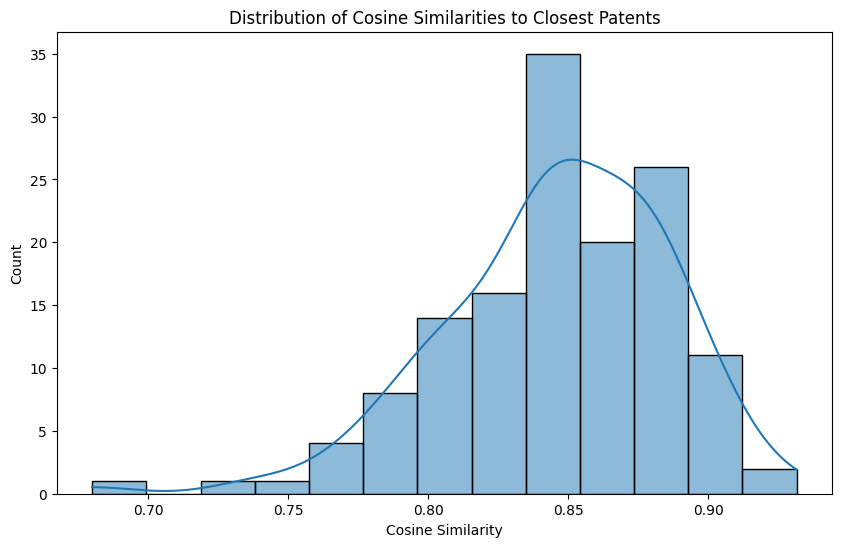

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

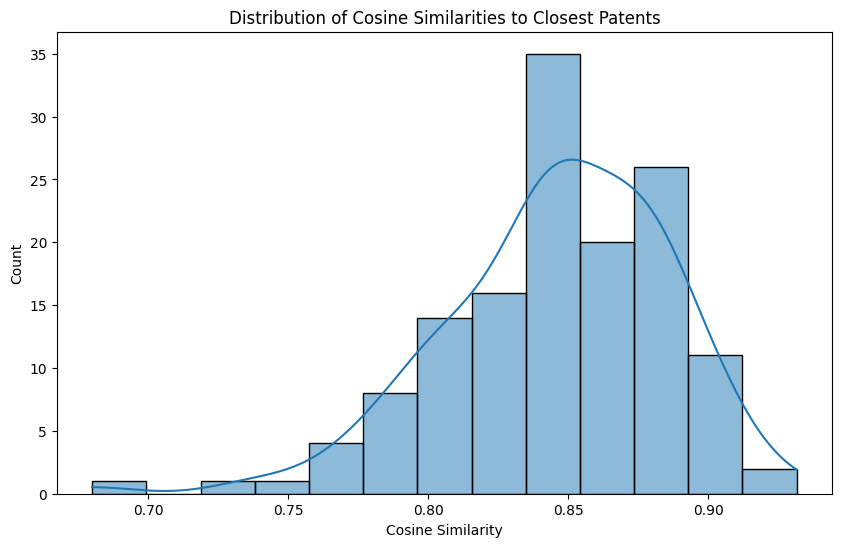

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

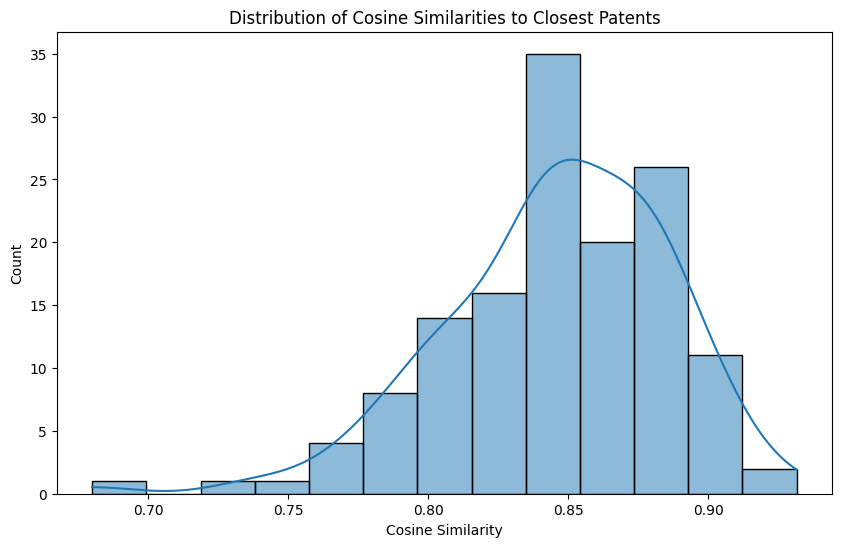

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

In [23]:
pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


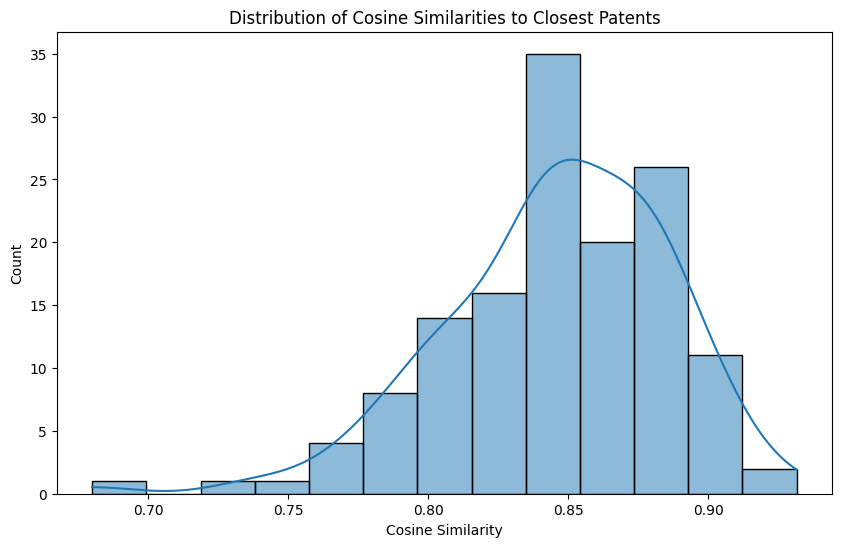

Number of patents with similarities calculated: 1135


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:

    cosine_similarities.append(patent.cosine_similarity_with_closest_patent)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:
    if patent.closest_patent is not None:
        similarity = 1 - cosine(patent.patent_embedding, patent.closest_patent.patent_embedding)
        cosine_similarities.append(similarity)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

ValueError: Input vector should be 1-D.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:
    if patent.closest_patent is not None:
        similarity = 1 - cosine(patent.patent_embedding, patent.closest_patent.patent_embedding)
        cosine_similarities.append(similarity)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

ValueError: Input vector should be 1-D.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:
    if patent.closest_patent is not None:
        similarity = 1 - cosine(patent.patent_embedding, patent.closest_patent.patent_embedding)
        cosine_similarities.append(similarity)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

ValueError: Input vector should be 1-D.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine
import seaborn as sns

# Calculate cosine similarities
cosine_similarities = []

for patent in patents:
    if patent.closest_patent is not None:
        similarity = 1 - cosine(patent.patent_embedding, patent.closest_patent.patent_embedding)
        cosine_similarities.append(similarity)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(cosine_similarities, kde=True)
plt.title("Distribution of Cosine Similarities to Closest Patents")
plt.xlabel("Cosine Similarity")
plt.ylabel("Count")
plt.show()

# Print some statistics
print(f"Number of patents with similarities calculated: {len(cosine_similarities)}")
print(f"Mean similarity: {np.mean(cosine_similarities):.4f}")
print(f"Median similarity: {np.median(cosine_similarities):.4f}")
print(f"Min similarity: {np.min(cosine_similarities):.4f}")
print(f"Max similarity: {np.max(cosine_similarities):.4f}")

ValueError: Input vector should be 1-D.